In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
# from google.colab import files
# files.upload()

In [3]:
# !ls -lha kaggle.json

In [4]:
# !pip install -q kaggle

In [5]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [6]:
# !chmod 600 /root/.kaggle/kaggle.json

In [7]:
# !pwd

In [8]:
# !kaggle datasets download -d kazanova/sentiment140

In [9]:
# !unzip sentiment140.zip

In [10]:
!ls

gdrive	sample_data


In [11]:
# !mv training.1600000.processed.noemoticon.csv data.csv

In [12]:
# !ls

In [13]:
!cp /content/gdrive/MyDrive/MIR-HW4/sentiment140.zip /content/

In [14]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [15]:
!mv training.1600000.processed.noemoticon.csv data.csv

In [16]:
!pip install unidecode
!pip install autocorrect
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 622 kB 8.0 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=602f1941eaf9195885c67e1f16c9670069564f12201675d1a84eeac1c6f12488
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.5 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installat

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import unidecode 
import re 
import time 
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json

import warnings
warnings.filterwarnings('ignore')


import transformers
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

from tqdm import tqdm

RANDOM_SEED = 76
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


device(type='cuda', index=0)

In [57]:
df = pd.read_csv("data.csv", header=None, encoding="latin-1")

In [58]:
df.shape

(1600000, 6)

In [59]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [60]:
df.columns = ['target', 'tweet_id', 'datetime', 'query', 'id', 'tweet']

In [61]:
df.head()

,target,tweet_id,datetime,query,id,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [62]:
len(df.id.unique())

659775

In [63]:
for t in df.tweet.head(10):
    print(t)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 


In [64]:
tweets_list = list(df.tweet)
tweet_len = list(map(len, tweets_list))
df["tweet_len"] = tweet_len

In [65]:
df.head()

,target,tweet_id,datetime,query,id,tweet,tweet_len
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111


In [66]:
df = df[df['tweet'].apply(lambda x : x.isascii())]

In [67]:
df['tweet'].apply(lambda x : x.isascii()).all()

True

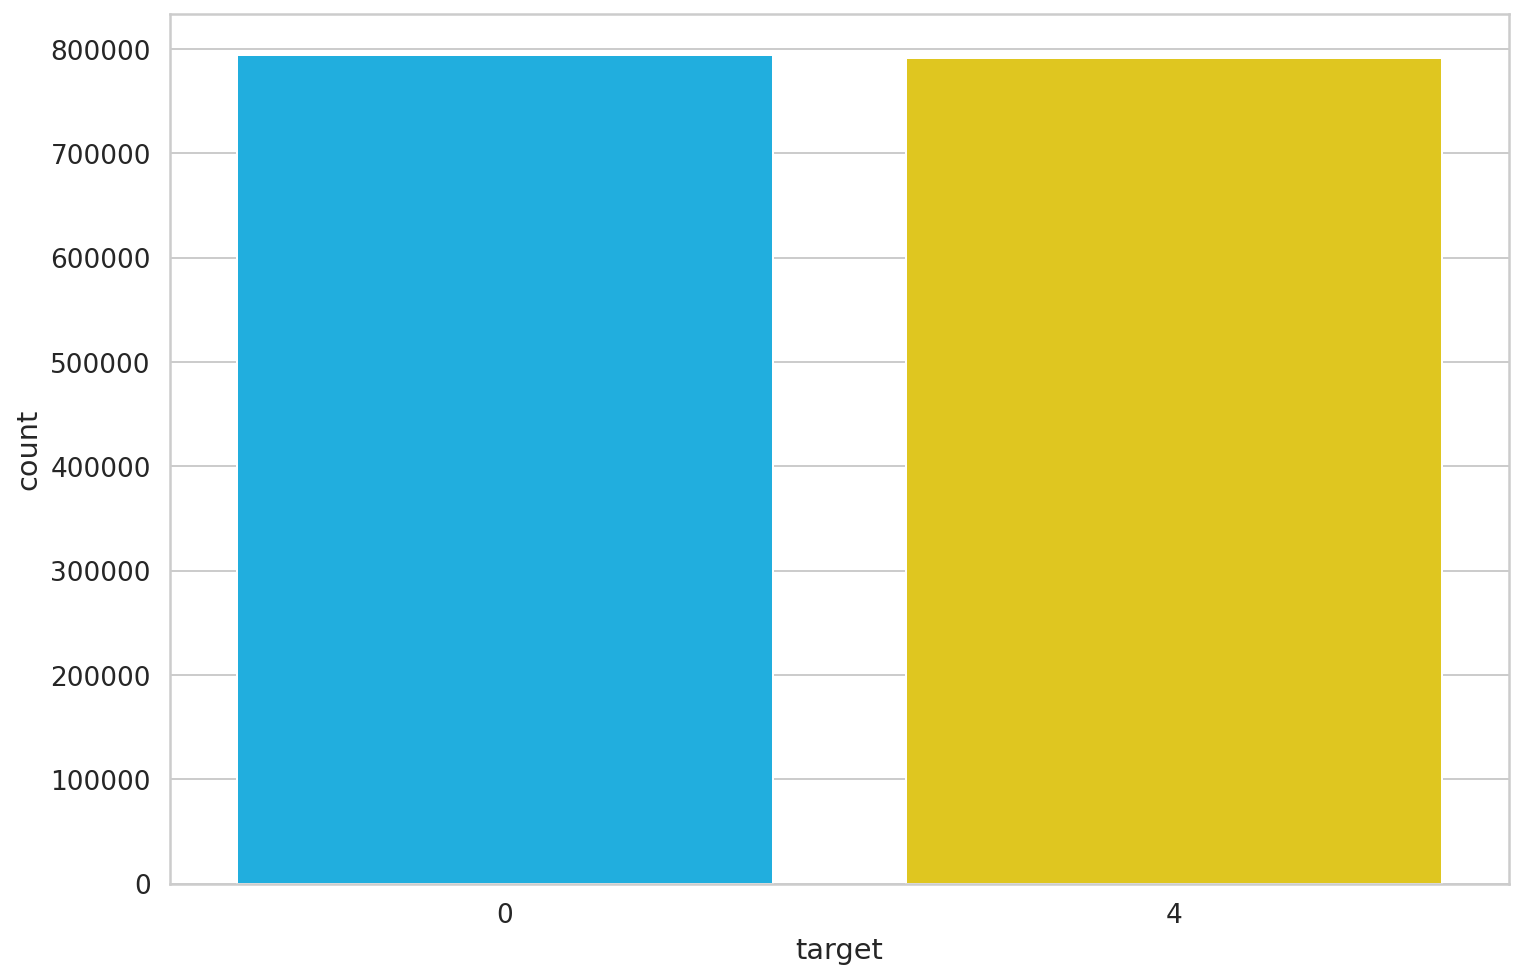

In [68]:
sns.countplot(df["target"]);

In [69]:
(df.target / 4).unique()

array([0., 1.])

In [70]:
df["target"] = df.target / 4

In [71]:
df.target.unique()

array([0., 1.])

In [72]:
df = df.sample(frac=1)

In [73]:
##################### Creating moc df for faster dvelepment, remove for the main run #####################
df = df[:600000]

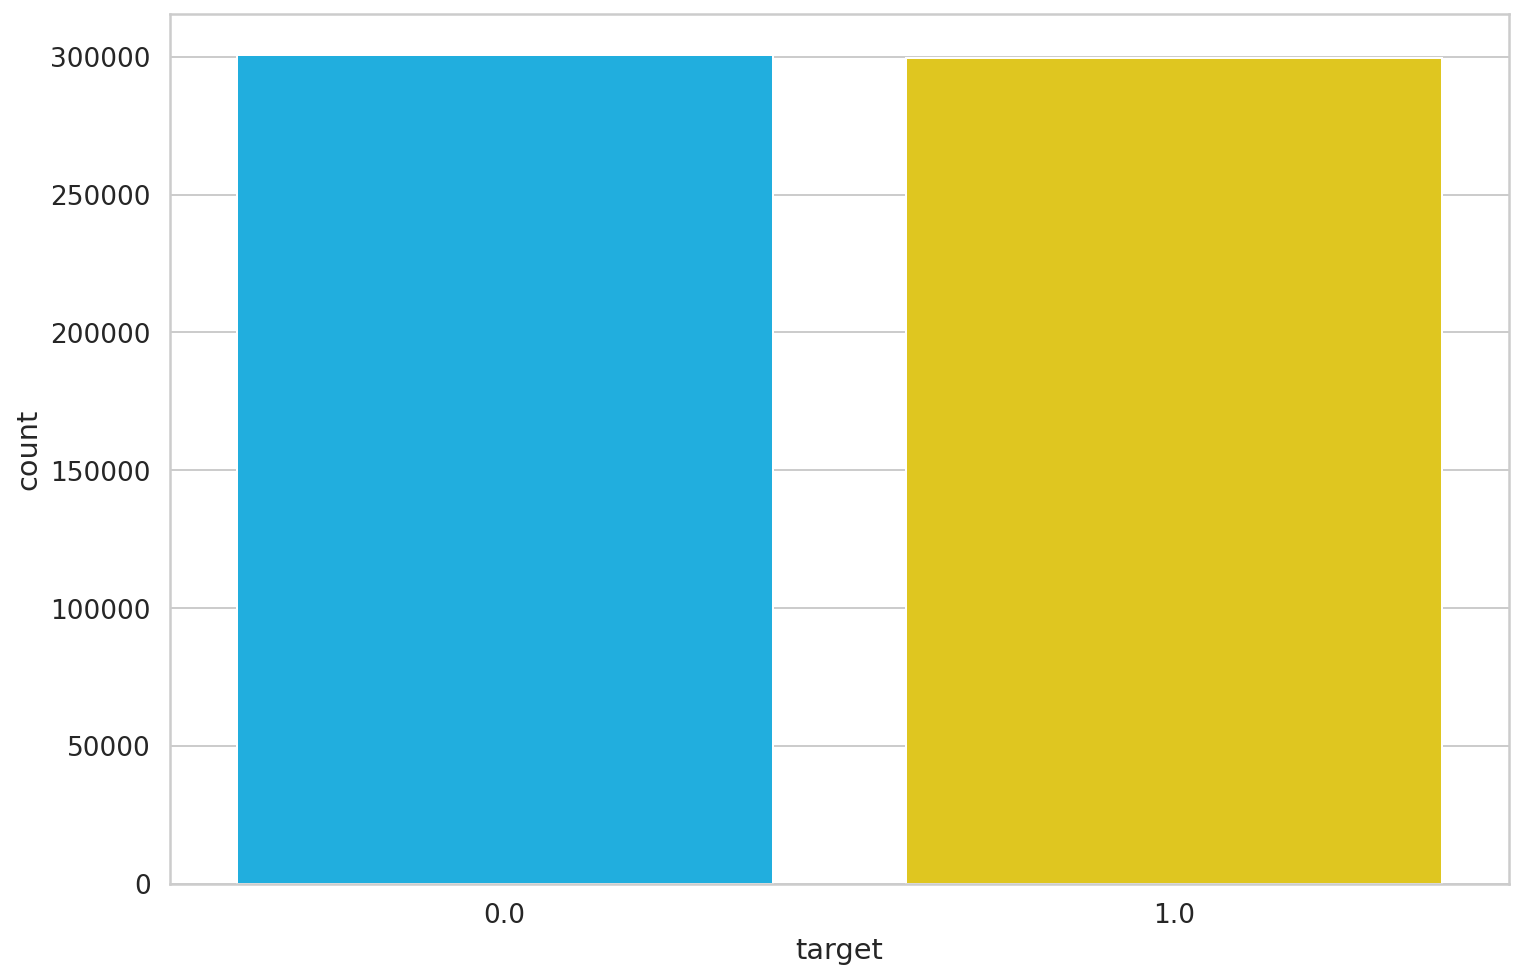

In [74]:
sns.countplot(df["target"]);

In [75]:
def remove_newlines_tabs(text):
    formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ')
    formatted_text = formatted_text.replace('\\', ' ').replace('. com', '.com')
    return formatted_text

def remove_mentions_hashtagSigns(text):
    tokenized = text.split(" ")
    formatted_text = ""
    for w in tokenized:
        if not w:
            continue
        if w[0] == "@":
            continue
        if w[0] == "#":
            formatted_text += f"{w[1:]} "
        else:
            formatted_text += f"{w} "
            
    return formatted_text.strip()

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_punctuations(text):
    formatted = ""
    for char in text:
        if char in string.punctuation:
            continue
        else:
            formatted += char
    return formatted

def remove_links(text):
    remove_https = re.sub(r'http\S+', '', text)
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

def accented_characters_removal(text):
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text)
    return text

def lower_casing_text(text):
    return text.lower()

def reducing_incorrect_character_repeatation(text):
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted


def expand_contractions(text, contraction_mapping):
    list_Of_tokens = text.split(' ')
    for Word in list_Of_tokens: 
         if Word in contraction_mapping: 
            list_Of_tokens = [item.replace(Word, contraction_mapping[Word]) for item in list_Of_tokens]
                
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
    return String_Of_tokens

def removing_special_characters(text):
    formatted_text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
    return formatted_text

def remove_numbers(text):
    formatted_text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
    return formatted_text

stoplist = stopwords.words('english') 
stoplist = set(stoplist)
def removing_stopwords(text):
    text = repr(text)
    No_StopWords = [word for word in word_tokenize(text) if word.lower() not in stoplist]
    words_string = ' '.join(No_StopWords)    
    return words_string

def spelling_correction(text):
    spell = Speller(lang='en')
    Corrected_text = spell(text)
    return Corrected_text

In [76]:
with open('/content/gdrive/MyDrive/MIR-HW4/contraction_map.json') as f:
    contraction_map = json.load(f)

def cleaning_and_preprocessing(tweet,
                              remove_newlines_=True,
                              remove_mentions_hashtagSigns_=True,
                              strip_html_tags_=True,
                              remove_punctuations_=True,
                              remove_links_=True,
                              remove_whitespace_=True,
                              accented_characters_removal_=True,
                              lower_casing_text_=True,
                              reducing_incorrect_character_repeatation_=True,
                              expand_contractions_=True,
                              remove_numbers_=True,
                              removing_stopwords_=True,
                              spelling_correction_=False):
    
    """
    input: a single text (e.g., a tweet or a sentence with type string).
    output: a single text (e.g., a tweet or a sentence with type string) which is clean:)
    """
    
    ## Cleaning
    text = tweet
    if remove_newlines_:
        text = remove_newlines_tabs(text)
    if remove_mentions_hashtagSigns_:
        text = remove_mentions_hashtagSigns(text)
    if strip_html_tags_:
        text = strip_html_tags(text)
    if remove_punctuations_:
        text = remove_punctuations(text)
    if remove_links_:
        text = remove_links(text)
    if remove_whitespace_:
        text = remove_whitespace(text)
    if  accented_characters_removal_:   
        text = accented_characters_removal(text)
    if lower_casing_text_:
        text = lower_casing_text(text)
    if reducing_incorrect_character_repeatation_:
        text = reducing_incorrect_character_repeatation(text)
    if expand_contractions_:
        text = expand_contractions(text, contraction_mapping=contraction_map)
    if remove_numbers_:
        text = remove_numbers(text)
    
    ## preprocessing
    if removing_stopwords_:
        text = removing_stopwords(text)
    if spelling_correction_:
        text = spelling_correction(text)
    return text


def lemmatization(text):
    """
        input: a single string text (e.g., tweet)
    """
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    return lemma    

In [77]:
def preprocess_all_tweets(df):
    """
        gets whole df as input.
        returns df with new column called cleaned tweets.
    """
    cleaned_tweets = []
    for tweet in tqdm(df.tweet):
        cleaned_tweet = cleaning_and_preprocessing(tweet)
        cleaned_tweets.append(cleaned_tweet)
    
    df["cleaned_tweets"] = cleaned_tweets
    return df


def lemmatize_all_tweets(df):
    """
        gets whole df as input.
        returns df with new column called lemmatized tweets.
    """
    lemmatized_tweets = []
    for tweet in tqdm(df.cleaned_tweets):
        lemmatized_tweet = cleaning_and_preprocessing(tweet)
        lemmatized_tweets.append(lemmatized_tweet)
    
    df["lemmatized_tweets"] = lemmatized_tweets
    return df

In [78]:
df = preprocess_all_tweets(df)
# df = lemmatize_all_tweets(df)

100%|██████████| 600000/600000 [02:56<00:00, 3397.51it/s]


In [79]:
df.head()

,target,tweet_id,datetime,query,id,tweet,tweet_len,cleaned_tweets
202325,0.0,1972099114,Sat May 30 08:33:28 PDT 2009,NO_QUERY,tannwick,Oh bugger it... #FACup,23,'oh bugger facup '
781471,0.0,2323427560,Thu Jun 25 00:37:09 PDT 2009,NO_QUERY,klvn89,Are we really going to stay in the whole day ...,87,'are really going stay whole day come spend in...
100475,0.0,1794005565,Thu May 14 04:40:51 PDT 2009,NO_QUERY,katie0509,is taking the hardest test of her life this mo...,83,'is taking hardest test life morning passing o...
1208745,1.0,1988853162,Sun May 31 23:34:02 PDT 2009,NO_QUERY,hollyxgoldyy,Still hasn't got out of bed :s btw people 2 we...,120,'still got bed btw people weeks til see beauti...
85829,0.0,1753945739,Sun May 10 04:15:18 PDT 2009,NO_QUERY,JBnVFCLover786,"@Angel_Christine yeah I know ugh, it's so not...",117,'yeah know ugh fair get nada get fun get see g...


In [80]:
df.target.unique()

array([0., 1.])

In [81]:
# pattern = r'''(?x)          # set flag to allow verbose regexps
#         (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
#       | \w+(?:-\w+)*        # words with optional internal hyphens
#       | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
#       | \.\.\.              # ellipsis
#       | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
#     '''

# pattern = re.compile(pattern)

# nltk_tokenized_tweets = [nltk.regexp_tokenize(tweet, pattern)[1:-1] for tweet in df.lemmatized_tweets]

# nltk_tokenized_tweets

# -----------------------------------------------------------------------------

In [101]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

configuration = BertConfig(num_attention_heads=6, num_hidden_layers=6, intermediate_size=2048)
model = BertModel(configuration)

In [102]:
sample_txt = df.cleaned_tweets.iloc[4]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 'yeah know ugh fair get nada get fun get see guys '
   Tokens: ["'", 'yeah', 'know', 'u', '##gh', 'fair', 'get', 'na', '##da', 'get', 'fun', 'get', 'see', 'guys', "'"]
Token IDs: [112, 8147, 1221, 190, 5084, 4652, 1243, 9468, 1810, 1243, 4106, 1243, 1267, 3713, 112]


In [103]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [104]:
class TweetsDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [105]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((480000, 8), (60000, 8), (60000, 8))

In [106]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetsDataset(
        tweets=df.cleaned_tweets.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)


BATCH_SIZE = 64
MAX_LEN = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [107]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 32])
torch.Size([64, 32])
torch.Size([64])


In [109]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = model

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

In [110]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, bert_model):
    super(SentimentClassifier, self).__init__()
    self.bert = bert_model
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [111]:
model = SentimentClassifier(n_classes=len(df.target.unique()), bert_model=bert_model)
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 32])
torch.Size([64, 32])


In [112]:
EPOCHS = 40

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [113]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [114]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/40
----------
Train loss 0.513166392370065 accuracy 0.7409166666666667
Val   loss 0.4719219011729206 accuracy 0.7723333333333333

Epoch 2/40
----------
Train loss 0.4669473567823569 accuracy 0.7769
Val   loss 0.4671738591910934 accuracy 0.7758

Epoch 3/40
----------
Train loss 0.45106570390462875 accuracy 0.7858812500000001
Val   loss 0.4691145095998036 accuracy 0.7750833333333333

Epoch 4/40
----------
Train loss 0.43555096811453503 accuracy 0.7953250000000001
Val   loss 0.4733180274078841 accuracy 0.7767666666666667

Epoch 5/40
----------
Train loss 0.41699439846475916 accuracy 0.8067708333333333
Val   loss 0.4899617334418714 accuracy 0.7724333333333334

Epoch 6/40
----------
Train loss 0.3940222200612227 accuracy 0.82176875
Val   loss 0.5220344974351591 accuracy 0.7645666666666667

Epoch 7/40
----------
